# Aggregation Operators for Face Recognition

# Implementation 

In [1]:
import cv2
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from PIL import Image
from mtcnn.mtcnn import MTCNN
from matplotlib.patches import Rectangle

from scipy.spatial.distance import euclidean

In [2]:
def calculate_disconnectedness(binary_image, subparts):
   components_sum = 0

   for subpart in subparts:
      component_moments = cv2.moments(subpart)
      components_sum += (component_moments['m00'] ** 3) * cv2.HuMoments(component_moments)[0][0]

   image_moments = cv2.moments(binary_image)

   return cv2.HuMoments(image_moments)[0][0] - (1 / (image_moments['m00'] ** 3)) * components_sum
    

In [3]:
def calculate_anisotropy(binary_image, subparts):
    C = 0
    B = 0
    A = 0

    for subpart in subparts:
        component_moments = cv2.moments(subpart) # TODO: change centroid moments to central moments
        C += (component_moments['m20'] + component_moments['m02']) * component_moments['m00']
        B += (component_moments['m20'] - component_moments['m02']) * component_moments['m00']
        A += 2 * (component_moments['m11'] * component_moments['m00'])

    return (C + np.sqrt(A**2 + B**2)) / (C - np.sqrt(A**2 + B**2))

In [4]:
def preprocess_image(image):
    # Apply Otsu's thresholding
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Optionally, perform connected component analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image)

    # Extract subparts based on connected components or intensity
    subparts = []
    for i in range(1, num_labels):
        region_mask = np.uint8(labels == i) * 255
        subparts.append(region_mask)

    # Optionally, apply morphological operations
    kernel = np.ones((5, 5), np.uint8)
    subparts = [cv2.morphologyEx(subpart, cv2.MORPH_CLOSE, kernel) for subpart in subparts]

    invariants = {}
    moments = cv2.moments(image)
    hu_moments = cv2.HuMoments(moments)

    invariants["Hu1"] = hu_moments[0][0] * 10**10
    invariants["Hu2"] = hu_moments[1][0] * 10**10
    invariants["Hu3"] = hu_moments[2][0] * 10**20
    invariants["Hu4"] = hu_moments[3][0] * 10**20
    invariants["Hu5"] = hu_moments[4][0] * 10**20
    invariants["Hu6"] = hu_moments[5][0] * 10**20
    invariants["Hu7"] = hu_moments[6][0] * 10**20
    invariants["Anisotropy"] = calculate_anisotropy(binary_image, subparts)
    invariants["Disconnectedness"] = calculate_disconnectedness(binary_image, subparts) * 10**10

    return invariants


In [5]:
def extract_face_from_file(filename, required_size=(160, 160)):
    # carregar imagens
    image = Image.open(filename)
    
    return extract_face(image, required_size)

def extract_face(image, required_size=(160, 160)):
    detector = MTCNN()
    
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    gray_face = cv2.cvtColor(face_array, cv2.COLOR_BGR2GRAY)
    
    return gray_face

In [6]:
train_data_face = []
test_data_face = []

train_data_brows = []
test_data_brows = []

train_data_eyes = []
test_data_eyes = []

train_data_nose = []
test_data_nose = []

train_data_mouth = []
test_data_mouth = []

train_data_left_cheek = []
test_data_left_cheek = []

train_data_right_cheek = []
test_data_right_cheek = []

for i in range(1, 16):
    for j in ['centerlight', 'glasses', 'happy', 'leftlight', 'noglasses', 'rightlight', 'sad', 'sleepy', 'surprised', 'wink']:
        image = extract_face_from_file(f'data/subject{i:02d}.{j}')

        train_data_face.append(preprocess_image(image) | {'target': i - 1})
        train_data_brows.append(preprocess_image(image[20:55, 10:150]) | {'target': i - 1})
        train_data_eyes.append(preprocess_image(image[50:80, 10:150]) | {'target': i - 1})
        train_data_nose.append(preprocess_image(image[65:115, 45:115]) | {'target': i - 1})
        train_data_mouth.append(preprocess_image(image[90:160, 0:40]) | {'target': i - 1})
        train_data_left_cheek.append(preprocess_image(image[115:145, 30:130]) | {'target': i - 1})
        train_data_right_cheek.append(preprocess_image(image[90:160, 120:160]) | {'target': i - 1})

    image = extract_face_from_file(f'data/subject{i:02d}.normal')

    test_data_face.append(preprocess_image(image) | {'target': i - 1})
    test_data_brows.append(preprocess_image(image[20:55, 10:150]) | {'target': i - 1})
    test_data_eyes.append(preprocess_image(image[50:80, 10:150]) | {'target': i - 1})
    test_data_nose.append(preprocess_image(image[65:115, 45:115]) | {'target': i - 1})
    test_data_mouth.append(preprocess_image(image[90:160, 0:40]) | {'target': i - 1})
    test_data_left_cheek.append(preprocess_image(image[115:145, 30:130]) | {'target': i - 1})
    test_data_right_cheek.append(preprocess_image(image[90:160, 120:160]) | {'target': i - 1})




1/1 [==============================] - 0s 73ms/step


In [7]:
train_data_face = pd.DataFrame(train_data_face)
train_data_face

train_data_brows = pd.DataFrame(train_data_brows)
train_data_brows

train_data_eyes = pd.DataFrame(train_data_eyes)
train_data_eyes

train_data_nose = pd.DataFrame(train_data_nose)
train_data_nose

train_data_mouth = pd.DataFrame(train_data_mouth)
train_data_mouth

train_data_left_cheek = pd.DataFrame(train_data_left_cheek)
train_data_left_cheek

train_data_right_cheek = pd.DataFrame(train_data_right_cheek)
train_data_right_cheek

,Hu1,Hu2,Hu3,Hu4,Hu5,Hu6,Hu7,Anisotropy,Disconnectedness,target
0,1.995572e+07,10852.996885,1.692466e+10,2.398689e+10,4.801427,1.925855e+07,0.551930,8.499597,5.344553e+06,0
1,1.360324e+07,4727.355574,3.482385e+09,1.954627e+08,-0.000732,-1.084487e+05,-0.001437,134.333640,2.025760e+06,0
2,1.482739e+07,6017.336330,5.843404e+09,2.164657e+09,0.063081,1.618500e+06,0.044133,96.374787,1.876786e+07,0
3,3.831736e+07,37301.094044,4.079764e+10,1.230423e+11,27.275683,1.729041e+08,82.799617,8.872970,1.224323e+07,0
4,1.218989e+07,4119.163096,1.052346e+07,7.730302e+08,-0.000548,4.426236e+05,0.000431,45.991241,2.196862e+07,0
...,...,...,...,...,...,...,...,...,...,...
145,1.212363e+07,3479.487350,5.992992e+08,4.519519e+08,0.001228,-2.715851e+04,-0.002006,9.814859,-5.490199e+05,14
146,1.832534e+07,8465.885306,4.103881e+09,3.683837e+09,0.074804,4.272643e+05,-0.122150,48.409726,5.031312e+07,14
147,1.868370e+07,8144.468510,1.874900e+10,1.743310e+10,3.122434,1.441732e+07,0.428828,8.184590,2.944929e+07,14
148,2.130613e+07,8558.794586,8.168876e+10,1.632581e+10,3.293495,6.909078e+05,-4.969762,50.441322,6.111203e+07,14


In [8]:
test_data_face = pd.DataFrame(test_data_face)
test_data_face

test_data_brows = pd.DataFrame(test_data_brows)
test_data_brows

test_data_eyes = pd.DataFrame(test_data_eyes)
test_data_eyes

test_data_nose = pd.DataFrame(test_data_nose)
test_data_nose

test_data_mouth = pd.DataFrame(test_data_mouth)
test_data_mouth

test_data_left_cheek = pd.DataFrame(test_data_left_cheek)
test_data_left_cheek

test_data_right_cheek = pd.DataFrame(test_data_right_cheek)
test_data_right_cheek

,Hu1,Hu2,Hu3,Hu4,Hu5,Hu6,Hu7,Anisotropy,Disconnectedness,target
0,1.379490e+07,5385.669416,1.834758e+09,6.697793e+08,0.007386,3.805584e+05,0.000755,79.753513,8.050581e+07,0
1,2.145316e+07,14015.895954,1.944360e+10,4.000628e+10,7.909871,3.315378e+07,7.869662,53.957867,-1.909388e+05,1
2,1.746279e+07,6879.410722,7.889831e+08,8.746059e+08,-0.004000,5.173481e+05,-0.006065,103.102067,7.668119e+07,2
3,1.466574e+07,4518.022092,1.405447e+09,1.038699e+10,0.309336,2.731200e+06,0.248620,26.454792,-8.822639e+04,3
4,1.981127e+07,8583.669865,1.371011e+10,8.632678e+09,0.116011,2.629566e+06,0.931966,115.495766,0.000000e+00,4
5,2.677173e+07,18494.503476,2.013543e+10,1.514152e+10,2.152863,1.947192e+07,-1.534619,41.211862,1.110845e+08,5
6,3.433529e+07,64479.718256,8.298860e+10,2.482169e+11,345.386265,5.744637e+08,-87.311188,98.280369,3.219877e+07,6
7,1.375034e+07,3305.387451,1.574113e+08,3.469250e+09,0.006743,-1.819620e+06,0.024735,19.052478,1.854513e+06,7
8,2.147093e+07,12979.284388,5.917985e+10,2.863673e+10,10.500500,2.790431e+07,-5.358812,11.721305,-3.722255e+05,8
9,2.142827e+07,14247.798101,5.294116e+09,6.961478e+09,0.258960,-1.807931e+06,0.333985,89.146958,2.518094e+07,9


In [9]:
X_train = [
    train_data_face.drop(['target', 'Hu2', 'Hu5', 'Hu6', 'Hu7', 'Anisotropy'], axis=1), # face
    train_data_brows.drop(['target', 'Hu1', 'Hu3', 'Hu4', 'Hu5', 'Hu6', 'Anisotropy', 'Disconnectedness'], axis=1), # eyebrows
    train_data_eyes.drop(['target', 'Hu1', 'Hu3', 'Hu4', 'Hu5', 'Hu6', 'Anisotropy', 'Disconnectedness'], axis=1), # eyes
    train_data_nose.drop(['target', 'Hu1', 'Hu2', 'Hu5', 'Hu6', 'Hu7', 'Anisotropy'], axis=1), # nose
    train_data_mouth.drop(['target', 'Hu1', 'Hu3', 'Hu4', 'Hu7', 'Anisotropy', 'Disconnectedness'], axis=1), # mouth
    train_data_left_cheek.drop(['target', 'Hu1', 'Hu3', 'Hu4', 'Hu5', 'Hu6', 'Hu7', 'Anisotropy', 'Disconnectedness'], axis=1), # left cheek
    train_data_right_cheek.drop(['target', 'Hu1', 'Hu6', 'Hu7', 'Anisotropy', 'Disconnectedness'], axis=1), # right cheek
]

y_train = [
    train_data_face["target"], # face
    train_data_brows["target"], # eyebrows
    train_data_eyes["target"], # eyes
    train_data_nose["target"], # nose
    train_data_mouth["target"], # mouth
    train_data_left_cheek["target"], # left cheek
    train_data_right_cheek["target"], # right cheek
]

X_test = [
    test_data_face.drop(['target', 'Hu2', 'Hu5', 'Hu6', 'Hu7', 'Anisotropy'], axis=1), # face
    test_data_brows.drop(['target', 'Hu1', 'Hu3', 'Hu4', 'Hu5', 'Hu6', 'Anisotropy', 'Disconnectedness'], axis=1), # eyebrows
    test_data_eyes.drop(['target', 'Hu1', 'Hu3', 'Hu4', 'Hu5', 'Hu6', 'Anisotropy', 'Disconnectedness'], axis=1), # eyes
    test_data_nose.drop(['target', 'Hu1', 'Hu2', 'Hu5', 'Hu6', 'Hu7', 'Anisotropy'], axis=1), # nose
    test_data_mouth.drop(['target', 'Hu1', 'Hu3', 'Hu4', 'Hu7', 'Anisotropy', 'Disconnectedness'], axis=1), # mouth
    test_data_left_cheek.drop(['target', 'Hu1', 'Hu3', 'Hu4', 'Hu5', 'Hu6', 'Hu7', 'Anisotropy', 'Disconnectedness'], axis=1), # left cheek
    test_data_right_cheek.drop(['target', 'Hu1', 'Hu6', 'Hu7', 'Anisotropy', 'Disconnectedness'], axis=1), # right cheek
]

y_test = [
    test_data_face["target"], # face
    test_data_brows["target"], # eyebrows
    test_data_eyes["target"], # eyes
    test_data_nose["target"], # nose
    test_data_mouth["target"], # mouth
    test_data_left_cheek["target"], # left cheek
    test_data_right_cheek["target"], # right cheek
]

In [10]:
X_train = [
    train_data_face.drop(['target', 'Hu1', 'Hu2', 'Hu3', 'Hu4', 'Hu5', 'Hu6', 'Hu7', 'Anisotropy'], axis=1), # face
    train_data_brows.drop(['target', 'Hu1', 'Hu2', 'Hu3', 'Hu4', 'Hu5', 'Hu6', 'Hu7', 'Anisotropy'], axis=1), # eyebrows
    train_data_eyes.drop(['target', 'Hu1', 'Hu2', 'Hu3', 'Hu4', 'Hu5', 'Hu6', 'Hu7', 'Anisotropy'], axis=1), # eyes
    train_data_nose.drop(['target', 'Hu1', 'Hu2', 'Hu3', 'Hu4', 'Hu5', 'Hu6', 'Hu7', 'Anisotropy'], axis=1), # nose
    train_data_mouth.drop(['target', 'Hu1', 'Hu2', 'Hu3', 'Hu4', 'Hu5', 'Hu6', 'Hu7', 'Anisotropy'], axis=1), # mouth
    train_data_left_cheek.drop(['target', 'Hu1', 'Hu2', 'Hu3', 'Hu4', 'Hu5', 'Hu6', 'Hu7', 'Anisotropy'], axis=1), # left cheek
    train_data_right_cheek.drop(['target', 'Hu1', 'Hu2', 'Hu3', 'Hu4', 'Hu5', 'Hu6', 'Hu7', 'Anisotropy'], axis=1), # right cheek
]

y_train = [
    train_data_face["target"], # face
    train_data_brows["target"], # eyebrows
    train_data_eyes["target"], # eyes
    train_data_nose["target"], # nose
    train_data_mouth["target"], # mouth
    train_data_left_cheek["target"], # left cheek
    train_data_right_cheek["target"], # right cheek
]

X_test = [
    test_data_face.drop(['target', 'Hu1', 'Hu2', 'Hu3', 'Hu4', 'Hu5', 'Hu6', 'Hu7', 'Anisotropy'], axis=1), # face
    test_data_brows.drop(['target', 'Hu1', 'Hu2', 'Hu3', 'Hu4', 'Hu5', 'Hu6', 'Hu7', 'Anisotropy'], axis=1), # eyebrows
    test_data_eyes.drop(['target', 'Hu1', 'Hu2', 'Hu3', 'Hu4', 'Hu5', 'Hu6', 'Hu7', 'Anisotropy'], axis=1), # eyes
    test_data_nose.drop(['target', 'Hu1', 'Hu2', 'Hu3', 'Hu4', 'Hu5', 'Hu6', 'Hu7', 'Anisotropy'], axis=1), # nose
    test_data_mouth.drop(['target', 'Hu1', 'Hu2', 'Hu3', 'Hu4', 'Hu5', 'Hu6', 'Hu7', 'Anisotropy'], axis=1), # mouth
    test_data_left_cheek.drop(['target', 'Hu1', 'Hu2', 'Hu3', 'Hu4', 'Hu5', 'Hu6', 'Hu7', 'Anisotropy'], axis=1), # left cheek
    test_data_right_cheek.drop(['target', 'Hu1', 'Hu2', 'Hu3', 'Hu4', 'Hu5', 'Hu6', 'Hu7', 'Anisotropy'], axis=1), # right cheek
]

y_test = [
    test_data_face["target"], # face
    test_data_brows["target"], # eyebrows
    test_data_eyes["target"], # eyes
    test_data_nose["target"], # nose
    test_data_mouth["target"], # mouth
    test_data_left_cheek["target"], # left cheek
    test_data_right_cheek["target"], # right cheek
]

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import xgboost as xgb

classifiers = [
    DecisionTreeClassifier(random_state=42),
    DecisionTreeClassifier(random_state=42),
    DecisionTreeClassifier(random_state=42),
    SVC(random_state=42),
    DecisionTreeClassifier(random_state=42),
    DecisionTreeClassifier(random_state=42),
    DecisionTreeClassifier(random_state=42),
]

In [12]:
for i in range(0, 7):
    classifiers[i].fit(X_train[i], y_train[i])

In [20]:
accuracies = []

for i in range(0, 7):
    y_pred = classifiers[i].predict(X_test[i])
    accuracies.append(accuracy_score(y_test[i], y_pred))
    print(accuracies[i])

0.7333333333333333
0.6666666666666666
0.6666666666666666
0.2
0.6
0.6
0.6666666666666666


In [14]:
accuracies

[0.7333333333333333,
 0.6666666666666666,
 0.6666666666666666,
 0.2,
 0.6,
 0.6,
 0.6666666666666666]

In [15]:
def get_g(beta, accuracies):
    g = []

    for i in range(0, 7):
        if i == 0:
            g.append(accuracies[i] * beta)
        else:
            g.append(accuracies[i] * (1. - beta))
    return g

Логика для поиска лямбды из уравнения $1 + \lambda = \prod_{g_i \in g}(1 + \lambda g_i)$

In [16]:
from sympy import solve, Symbol

x = Symbol('x')

def func(g):
    y = 1

    for g_i in g:
        y *= (1 + x * g_i)

    y -= 1 + x
    return y

def get_lambda(g):
    for i in solve(func(g), x):
        if i > -1 and i <= 1:
            return i
    return 0 # if no lambdas are suitable

Поиск необходимых для расчета интеграла Чокет элементов $g_{\lambda}$-нечеткой величины

In [17]:
def get_g_A(g, lambda_value):
    g_A = [
        g[0]
    ]

    for i in range(1, 7):
        g_A.append(g_A[i - 1] + g[i] + lambda_value * g_A[i - 1] * g[i])
    
    return g_A


In [18]:
def eval_accuracy(classifiers, X_train, X_test, y_train, y_test, g_A, beta):
    y_pred = []

    for im_index in range (0, 15): # для каждой тестовой картинки
        y_t_pred = set()
        for i in range(0, 7): # смотрим предсказания отдельных классификаторов
            y_t_pred.add(classifiers[i].predict(X_test[i])[im_index])

        y_t_pred = list(y_t_pred)

        f_ik = np.zeros((len(y_t_pred), 7))

        for k_ind in range(len(y_t_pred)): # оцениваем все предсказанные классы
            for i in range(0, 7): # в контексте всех классификаторов
                mu_ij = []
                d_i = 0
                for l in range(0, 10): # считаем среднюю дистанцию от тестового изображения до тренировочных изображений предсказанного класса
                    d_i += euclidean(X_test[i].iloc[im_index], X_train[i].iloc[10 * y_t_pred[k_ind] + l])

                for j in range(0, 10): # считаем дистанцию от тестового изображения до конкретного тренировочного изображения предсказанного класса
                    d_ij = euclidean(X_test[i].iloc[im_index], X_train[i].iloc[10 * y_t_pred[k_ind] + j])
                    test = d_i / 10.
                    mu_ij.append(1. / (1. + (d_ij / test))) # заполняем меры принадлежности k-тому предсказанному классу, используя все 7 классификаторов

                f_ik[k_ind][i] = (1. / 10) * np.sum(mu_ij) # используя меры принадлежности классификаторов, высчитываем максимальную меру принадлежности

        index_arrays = [] # используем массив индексов, так как нам нужно обращаться к элементам f_ik и g_A в определенном порядке, определенным сравнением элементов f_ik
        for array in f_ik:
            index_arrays.append(np.argsort(array))

        choquet_int = [0] * len(y_t_pred) # для каждого предсказания рассчитываем Чокет интеграл
        for k in range(len(y_t_pred)):
            for sorted_index in range(6, -1, -1):
                i = index_arrays[k][sorted_index]

                f_k1 = 0 if i == 6 else f_ik[k][i + 1]
                f_k = f_ik[k][i]

                choquet_int[k] += (f_k - f_k1) * g_A[i] # высчитываем аппроксимацию интеграла Чокет

        y_pred.append(y_t_pred[np.argmax(choquet_int)]) # считаем предсказанием элемент с наимбольшим значением интеграла Чокет

    print(f"Model accuracy (Beta={beta}): {accuracy_score(y_test[i], y_pred)}")
    return accuracy_score(y_test[i], y_pred)

In [23]:
betas = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]
aggregation_accuracies = []

for beta in betas:
    g = get_g(beta, accuracies)
    g_A = get_g_A(g, get_lambda(g))

    aggregation_accuracies.append(eval_accuracy(classifiers, X_train, X_test, y_train, y_test, g_A, beta))

Model accuracy (Beta=0.0): 0.7333333333333333
Model accuracy (Beta=0.1): 0.7333333333333333
Model accuracy (Beta=0.2): 0.8
Model accuracy (Beta=0.3): 0.8
Model accuracy (Beta=0.4): 0.8
Model accuracy (Beta=0.5): 0.9333333333333333
Model accuracy (Beta=0.6): 0.8666666666666667
Model accuracy (Beta=0.7): 0.8
Model accuracy (Beta=0.8): 0.7333333333333333
Model accuracy (Beta=0.9): 0.7333333333333333
Model accuracy (Beta=1.0): 0.7333333333333333


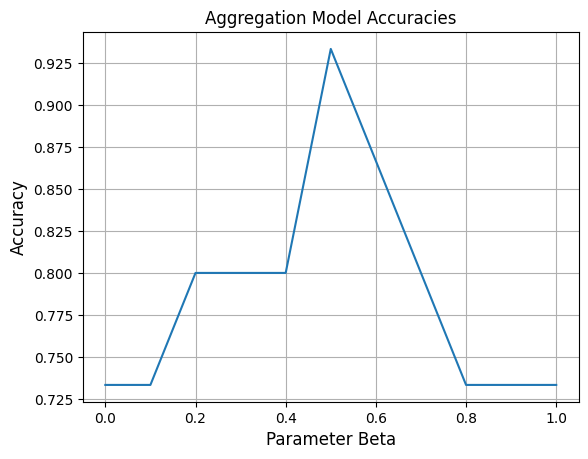

In [28]:
plt.plot(betas, aggregation_accuracies)
plt.title("Aggregation Model Accuracies")
plt.xlabel('Parameter Beta', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True)